In [1]:
import pickle
import os
import functools
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.7"

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import scipy.stats

from itertools import product

import pandas as pd

from olympus.event_generation.photon_propagation.norm_flow_photons import  NormFlowPhotonLHPerModule
from olympus.event_generation.detector import make_hex_grid, Detector, sample_cylinder_volume, sample_direction, get_proj_area_for_zen

from olympus.event_generation.lightyield import  make_realistic_cascade_source, fennel_total_light_yield
from olympus.event_generation.utils import track_isects_cyl, sph_to_cart_jnp

from hyperion.medium import medium_collections
from hyperion.constants import Constants


from jax import random, vmap, jit
from jax import numpy as jnp

import nuSQuIDS as nsq
from scipy.interpolate import RectBivariateSpline, UnivariateSpline
import h5py


import json
%matplotlib inline
import jax
print(jax.devices())


2022-04-06 22:14:45.070367: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/cuda-11/lib64/:/opt/LeptonInjector/install:/usr/local/cuda-11/lib64/:/usr/local/nvidia/lib:/usr/local/nvidia/lib64/
2022-04-06 22:14:45.070753: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


[CpuDevice(id=0)]


# Effective Area Calculation

## Setup

In [2]:
# Medium settings
path_to_config = "../../hyperion/data/pone_config_pessimistic.json"
config = json.load(open(path_to_config))["photon_propagation"]
ref_ix_f, sca_a_f, sca_l_f, abs_len_f = medium_collections[config["medium"]]

def c_medium_f(wl):
    """Speed of light in medium for wl (nm)."""
    return Constants.BaseConstants.c_vac / ref_ix_f(wl)

# Load normalizing flow likelihood module, will provide expected photon counts
photon_lh = NormFlowPhotonLHPerModule(
    "../../hyperion/data/photon_arrival_time_nflow_params_pessimistic.pickle",
    "../../hyperion/data/photon_arrival_time_counts_params_pessimistic.pickle",
    2000,
    c_medium=c_medium_f(700) / 1E9)

# Light yields for realistic cascades
converter_func = functools.partial(make_realistic_cascade_source, moliere_rand=True, resolution=0.2)

# Vectorize expected counts function over detector modules / efficiencies
nph_expec_v = vmap(photon_lh.expected_photons_for_sources, in_axes=[0, 0, None, None, None, None])

# Define "trigger"
def calc_trigger(coords, effs, dir, pos, energy, key, hit_threshs):
    """
    Counts how many modules see more than `hit_threshs` photons.
    
    Parameters:
        coords: array[N, 3]
            Module coordinates
        effs: array[N, 1]
            Module efficiences
        dir: array[3]
            Neutrino direction
        pos: array[3]
            Interaction vertex
        energy: float
            Deposited energy
        key: PRNGKey
        hit_threshs: iterable
            Iterable containing hit thresholds

    Returns:
        List of how many modules see more than hit_threshs photons
    """

    sources = converter_func(dir=dir, pos=pos, key=key, t0=0, energy=energy, particle_id=11)
    nph_per_mod = nph_expec_v(
        coords,
        effs,
        *sources).sum(axis=1)

    trig_counts = [jnp.sum(nph_per_mod > i) for i in hit_threshs]

    return trig_counts

# Vectorize trigger function over event directions, positions, energies and random keys
calc_trigger_v = jit(vmap(calc_trigger, in_axes=[None, None, 0, 0, 0, 0, None]))


In [49]:
( 16 * (pmt_cath_area_r)**2) / (0.254 / 2) **2 

1.39500279000558

In [3]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50 # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100 # m
pmts_per_module = 16
pmt_cath_area_r = 75E-3 / 2 # m
module_radius = 0.21 # m

# Calculate the relative area covered by PMTs
efficiency = pmts_per_module * (pmt_cath_area_r)**2 * np.pi / (4*np.pi*module_radius**2)


In [20]:
fennel_total_light_yield(1E5, 11, [250, 700]) * 0.21**2 / 50**2 * np.exp(-50/25)

DeviceArray(109042.64, dtype=float32)

/opt/conda/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2565: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")


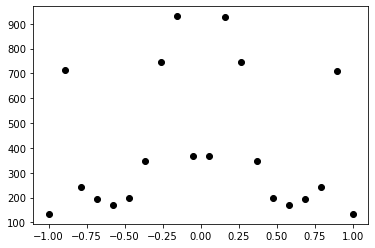

In [47]:
dir = jnp.asarray([0, 0, 1.])
pos = jnp.asarray([0, 0, 0.])


key = random.PRNGKey(0)
det = Detector(make_hex_grid(3, 100, 20, 50, dark_noise_rate, rng, efficiency=efficiency, truncate=1))
zeniths = np.arccos(np.linspace(-1, 1, 20))
for zenith in zeniths:

    dir = sph_to_cart_jnp(zenith, 0)
    sources = converter_func(dir=dir, pos=pos, key=key, t0=0, energy=1E5, particle_id=11)
    nph_per_mod = nph_expec_v(
        det.module_coords,
        det.module_efficiencies,
        *sources).sum(axis=1)
    plt.plot(np.cos(zenith), np.max(nph_per_mod), "ok")




In [42]:
np.max(nph_per_mod)

DeviceArray(134.01613, dtype=float32)

[]

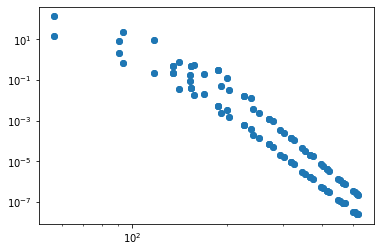

In [41]:

plt.scatter(jnp.linalg.norm(det.module_coords - pos, axis=1), nph_per_mod)
plt.loglog()

Text(0, 0.5, 'y [m]')

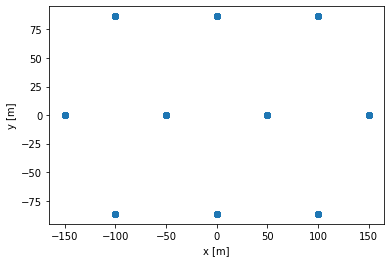

In [5]:
det = Detector(make_hex_grid(3, 100, 20, 50, dark_noise_rate, rng, efficiency=efficiency, truncate=1))
module_positions = jnp.asarray(det.module_coords)

plt.scatter(module_positions[:, 0], module_positions[:, 1])
plt.xlabel("x [m]")
plt.ylabel("y [m]")

## Acceptance Calculation

In [12]:
def calc_acceptance_for_det(det, rng, key, energies, mod_threshs, hit_threshs):
    
    nev = 1000
    nev_batch = 10

    cylinder_height=det._outer_cylinder[1] + 100
    cylinder_radius=det._outer_cylinder[0] + 50

    n_batches = int(np.ceil(nev / nev_batch))
    dirs = sample_direction(nev, rng)
    poss = sample_cylinder_volume(cylinder_height, cylinder_radius, nev, rng)

    all_trig_counts = []

    for e in energies:

        tcpe = []

        for i in range(n_batches):
            
            key, subkey = random.split(key)
            
            this_dirs = dirs[i*nev_batch: (i+1)*nev_batch]
            this_pos = poss[i*nev_batch: (i+1)*nev_batch]

            trig_counts = calc_trigger_v(
                det.module_coords,
                det.module_efficiencies,
                this_dirs,
                this_pos,
                jnp.full(this_dirs.shape[0], e),
                random.split(subkey, this_dirs.shape[0]),
                hit_threshs)

            tcpe.append(np.asarray(trig_counts))
        all_trig_counts.append(tcpe)

    arr = np.swapaxes(np.asarray(all_trig_counts), 1, 2)
    arr = arr.reshape(*arr.shape[:2], -1)


    acc_spline_dict = {}

    for mt, ht_ix in product(mod_threshs, range(len(hit_threshs))):
        acc_frac = np.sum(arr[:, ht_ix] > mt, axis=-1)/ nev
        spline = UnivariateSpline(np.log10(energies), acc_frac, s=0, k=1)
        acc_spline_dict[(mt, hit_threshs[ht_ix])] = spline

    return acc_spline_dict



spacings = np.concatenate([[30, 40], np.linspace(50, 200, 6)])

rng = np.random.RandomState(0)
key = random.PRNGKey(0)

energies = np.logspace(2, 6, 25)
mod_threshs = np.arange(1, 6)
hit_threshs = np.arange(1, 6)

acc_dicts = []


In [ ]:

for spacing in spacings:

    det = Detector(make_hex_grid(3, spacing, 20, 50, dark_noise_rate, rng, efficiency=efficiency, truncate=1))
    key, subkey = random.split(key)
    res = calc_acceptance_for_det(det, rng, subkey, energies, mod_threshs, hit_threshs)
    

    for k, v in res.items():
        acc_dicts.append({
            "module_threshold": k[0],
            "hit_threshold": k[1],
            "spacing": spacing,
            "acceptance": v
        })

In [8]:
acc_df = pd.DataFrame(acc_dicts).set_index(["module_threshold", "hit_threshold", "spacing"])
pd.to_pickle(acc_df, "../data/em_casc_trigger_accept.pickle")

In [4]:
acc_df = pd.read_pickle("../data/em_casc_trigger_accept.pickle")

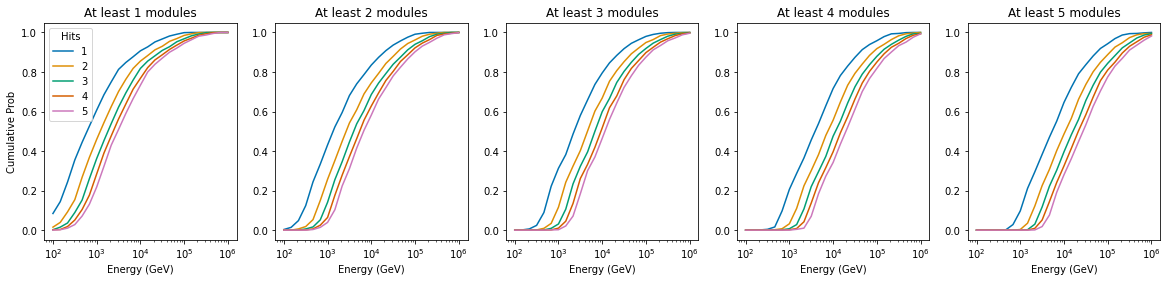

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(4*5, 4))
selected = acc_df.loc[(slice(None), slice(None), 50)]

ht_vals = selected.index.get_level_values(1)

colors = sns.color_palette("colorblind",len(ht_vals))

for ax, (mt, mt_group) in zip(axs, selected.groupby(level=0)):
    for col, (ht, ht_group) in zip(colors, mt_group.groupby(level=1)):
        spline = ht_group["acceptance"].values[0]

        ax.plot(energies, spline(np.log10(energies)), color=col, label=f"{ht}")

    ax.set_xscale("log")
    ax.set_title(f"At least {mt} modules")
    ax.set_xlabel("Energy (GeV)")

axs[0].set_ylabel("Cumulative Prob")
axs[0].legend(title="Hits")
plt.savefig("../figures/em_casc_cluster_nhits_nmods_edep.png", dpi=150)


## Transmission Probability

In [5]:
units = nsq.Const()
interactions = True

E_min = 1.0e2*units.GeV
E_max = 1.0e8*units.GeV
E_nodes = 200
energy_nodes = nsq.logspace(E_min,E_max,E_nodes)

neutrino_flavors = 3

nuSQ = nsq.nuSQUIDS(energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)


N0 = 1.0e18; Power = -1.0
Eflux = lambda E: N0*E**Power

InitialFlux = np.zeros((E_nodes,2,3))
InitialFlux[:] = Eflux(nuSQ.GetERange()).reshape((E_nodes, 1, 1))


nuSQ.Set_rel_error(1.0e-7)
nuSQ.Set_abs_error(1.0e-7)
#nuSQ.Set_h_max(500.0*units.km)
nuSQ.Set_MixingParametersToDefault()

n_thetas = 50
flux_ratio_theta =  np.zeros((E_nodes, n_thetas, 2 ,3))
cthetas = np.linspace(-1, 1, n_thetas)
n_energies = len(nuSQ.GetERange())
for j, ctheta in enumerate(cthetas):
    earth = nsq.EarthAtm()
    nuSQ.Set_Body(earth)
    nuSQ.Set_Track(nsq.EarthAtm.Track(earth.MakeTrackWithCosine(ctheta)))
    nuSQ.Set_initial_state(InitialFlux,nsq.Basis.flavor)
    nuSQ.Set_TauRegeneration(True)

    nuSQ.EvolveState()


    for nutype, nuflavor, i_energy in product(range(2), range(3), range(n_energies)):
        flux_ratio_theta[i_energy, j, nutype, nuflavor] = (
            nuSQ.EvalFlavorAtNode(nuflavor, i_energy, nutype) /
            InitialFlux[i_energy][nutype][nuflavor]
        )

log10_energies = np.log10(nuSQ.GetERange()/units.GeV)
transmission_prob_spline = RectBivariateSpline(cthetas, log10_energies, flux_ratio_theta[:, :, 0, 0].T)


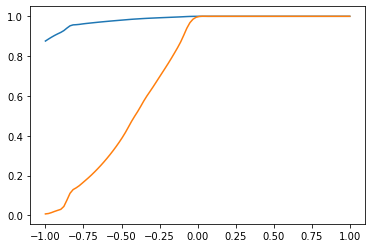

In [5]:
cs = np.linspace(-1, 1, 100)
plt.plot(cs, transmission_prob_spline(cs, np.log10(1E4), grid=False))
plt.plot(cs, transmission_prob_spline(cs, np.log10(1E6), grid=False))

## Cross Section

In [6]:
with h5py.File("/opt/nuSQuIDS/data/xsections/csms_square.h5") as f:
    log10etbl = f["energies"][:]

    min_e = 10**np.min(log10etbl)
    xsec_spline = RectBivariateSpline(log10etbl, f["zs"],  f["dsdy_CC_nu"][:])

    avg_nu_nubar = 0.5*(f["dsdy_CC_nu"][:] + f["dsdy_CC_nubar"][:])

    xsec_spline_energy = UnivariateSpline(log10etbl-9, np.trapz(avg_nu_nubar, f["zs"], axis=0), s=0, k=1)
    z = lambda E_lep, E_nu : (E_lep - min_e)/(E_nu - min_e)


In [9]:
plt.plot(log10etbl-9, xsec_spline_energy(log10etbl-9))
plt.ylim(-38, -30)
plt.xlabel("log10(E/GeV)")

NameError: name 'log10etbl' is not defined

## Effective Area

In [7]:
pos_acc_df = pd.read_pickle("../data/em_casc_pos_uncert_accept_fisher.pickle")
pos_acc_df = pos_acc_df.loc[(slice(None), "Full pessimistic cluster", slice(None), slice(None), 16)]

In [9]:
molar_mass_water = 18.01528 # g / mol
density = 1000 # kg / m^3
na = 6.02214076E23 # 1 / mol
n_nucleons = 18 * density / (molar_mass_water / 1000) * na # 1 / m^3


a_eff_cos_bins = np.linspace(-1, 1, 40)
a_eff_e_bins = np.linspace(3, 6, 41)
a_effs = []



In [11]:

aeff_hists = []
nsample = int(1E6)
for spacing, spacing_group in acc_df.groupby(level=2):

    det = Detector(make_hex_grid(3, spacing, 20, 50, dark_noise_rate, rng, efficiency=efficiency, truncate=1))
    cylinder_height=det._outer_cylinder[1] + 100
    cylinder_radius=det._outer_cylinder[0] + 50
    cylinder_volume=cylinder_height * cylinder_radius**2 * np.pi

    dirs = sample_direction(nsample, rng)
    poss = sample_cylinder_volume(cylinder_height, cylinder_radius, nsample, rng)
    logesmpl = np.random.uniform(3, 6, nsample)

    xs = 10**(xsec_spline_energy(logesmpl)) * 1E-4 # m^2
    interaction_coeff = xs * n_nucleons

    transmission_probs = transmission_prob_spline(dirs[:, 2], logesmpl, grid=False)

    chord_lengths = []
    proj_areas = []

    for p, d in zip(poss, dirs):
        isec_ps = track_isects_cyl(cylinder_radius, cylinder_height, p, d)
        proj_area = get_proj_area_for_zen(cylinder_height, cylinder_radius, d[2])
        
        chord_lengths.append(np.abs(np.diff(isec_ps)).item())
        proj_areas.append(proj_area)
    chord_lengths = np.asarray(chord_lengths)
    proj_areas = np.asarray(proj_areas)

    #taylor: 1 - exp(-x) ~ x
    int_prob = interaction_coeff * chord_lengths

    total_prob = int_prob * transmission_probs

    eff_areas_contribs = total_prob * proj_areas
    eff_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_areas_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))

    eff_volume_contribs = np.ones_like(total_prob) * cylinder_volume
    eff_v_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_volume_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))

    aeff_hists.append(
        {
            "hit_threshold": None,
            "module_threshold": None,
            "spacing": spacing,
            "aeff_hist": eff_hist.statistic,
            "veff_hist": eff_v_hist.statistic,
            "min_pos_resolution": None
        })


    for (mt, ht), mt_ht_group in spacing_group.groupby(level=[0, 1]):
        if len(mt_ht_group) > 1:
            raise RuntimeError()
        acc_prob = mt_ht_group["acceptance"].values[0](logesmpl)
        total_prob = int_prob * transmission_probs * acc_prob

        eff_areas_contribs = total_prob * proj_areas
        eff_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_areas_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))

        eff_volume_contribs = acc_prob * cylinder_volume
        eff_v_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_volume_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))
        aeff_hists.append(
            {
                "hit_threshold": ht,
                "module_threshold": mt,
                "spacing": spacing,
                "aeff_hist": eff_hist.statistic,
                "veff_hist": eff_v_hist.statistic,
                "min_pos_resolution": None
            })

        if spacing in pos_acc_df.index.levels[1]:

            for min_pos_res, pra_grp in pos_acc_df.loc[(slice(None), spacing, slice(None))].groupby(level=0):
                spline = UnivariateSpline(np.log10(pra_grp.index.levels[1]), pra_grp.values, s=0, k=1)
                pos_acc = spline(logesmpl)

                eff_areas_contribs = total_prob * proj_areas * pos_acc
                eff_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_areas_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))

                eff_volume_contribs = acc_prob * cylinder_volume * pos_acc
                eff_v_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_volume_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))

                aeff_hists.append(
                {
                    "hit_threshold": ht,
                    "module_threshold": mt,
                    "spacing": spacing,
                    "aeff_hist": eff_hist.statistic,
                    "veff_hist": eff_v_hist.statistic,
                    "min_pos_resolution": min_pos_res
                })




"""
for mt, ht, spacing_ix in product(mod_threshs, hit_threshs, range(len(spacings))):



    acc_prob = acc_dicts[spacing_ix][(mt, ht)](logesmpl)
    total_prob_cd = column_density * transmission_probs * acc_prob


    eff_areas_contribs = []
    for p, d, prob in zip(poss, dirs, total_prob_cd):
        isec_ps = track_isects_cyl(cylinder_radius, cylinder_height, p, d)
        proj_area = get_proj_area_for_zen(cylinder_height, cylinder_radius, d[2])
        # taylor
        int_prob = prob * isec_ps[1]
        eff_areas_contribs.append(proj_area * int_prob)
    aeff_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_areas_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))
"""
    

   







'\nfor mt, ht, spacing_ix in product(mod_threshs, hit_threshs, range(len(spacings))):\n\n\n\n    acc_prob = acc_dicts[spacing_ix][(mt, ht)](logesmpl)\n    total_prob_cd = column_density * transmission_probs * acc_prob\n\n\n    eff_areas_contribs = []\n    for p, d, prob in zip(poss, dirs, total_prob_cd):\n        isec_ps = track_isects_cyl(cylinder_radius, cylinder_height, p, d)\n        proj_area = get_proj_area_for_zen(cylinder_height, cylinder_radius, d[2])\n        # taylor\n        int_prob = prob * isec_ps[1]\n        eff_areas_contribs.append(proj_area * int_prob)\n    aeff_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_areas_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))\n'

In [96]:


np.cos(np.degrees(95))

-0.28574274472927647

In [8]:
def sample_downgoing(nsample, rng):
    theta = np.arccos(rng.uniform(np.cos(np.degrees(95)), 1, size=nsample))
    phi = rng.uniform(0, 2*np.pi, size=nsample)

    return np.stack([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)], axis=1)


In [11]:
#det = Detector(make_hex_grid(3, spacing, 20, 50, dark_noise_rate, rng, efficiency=efficiency, truncate=1))
nsample = (int(1E6))
rng = np.random.RandomState(10)
cylinder_height=1000 + 100
cylinder_radius=500 + 50

dirs = sample_downgoing(nsample, rng)
poss = sample_cylinder_volume(cylinder_height, cylinder_radius, nsample, rng)
logesmpl = np.random.uniform(3, 6, nsample)

xs = 10**(xsec_spline_energy(logesmpl)) * 1E-4 # m^2
column_density = xs * n_nucleons

transmission_probs = transmission_prob_spline(dirs[:, 2], logesmpl, grid=False)

dist_before = []
proj_areas = []

for p, d in zip(poss, dirs):
    isec_ps = track_isects_cyl(cylinder_radius, cylinder_height, p, d)
    proj_area = get_proj_area_for_zen(cylinder_height, cylinder_radius, d[2])
    dist_before.append(np.abs(np.diff(isec_ps)).item())
    proj_areas.append(proj_area)



dist_before = np.asarray(dist_before)
proj_areas = np.asarray(proj_areas)


#taylor: 1 - exp(-x) ~ x
int_prob = column_density * dist_before 
total_prob = int_prob * transmission_probs

eff_areas_contribs = total_prob * proj_areas

eff_hist = scipy.stats.binned_statistic(logesmpl, eff_areas_contribs, bins= a_eff_e_bins)




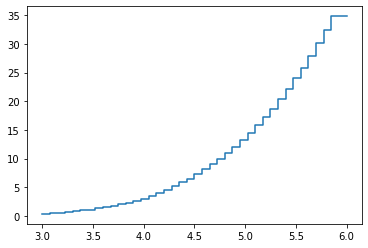

In [13]:
plt.step(a_eff_e_bins, np.append(eff_hist[0], eff_hist[0][-1]))

In [57]:
track_isects_cyl(cylinder_radius, cylinder_height, np.asarray([-550, 0, 0]), np.asarray([1, 0, 0]))

(0.0, 1100.0)

In [50]:
10**xsec_spline_energy(6)

4.837063141754472e-34

In [53]:
density / 1.67E-27

5.988023952095808e+29

In [51]:
1 / 1.67E-27 # kg

5.988023952095808e+26

In [14]:
aeff_df = pd.DataFrame(aeff_hists).set_index(["hit_threshold", "module_threshold", "min_pos_resolution", "spacing", ])
pickle.dump((a_eff_cos_bins, a_eff_e_bins, aeff_df), open("../data/aeff_cluster_nuecc.pickle", "wb"))
#a_eff_cos_bins, a_eff_e_bins, aeff_df = pickle.load(open("../data/aeff_cluster_nuecc.pickle", "rb"))

/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: ind

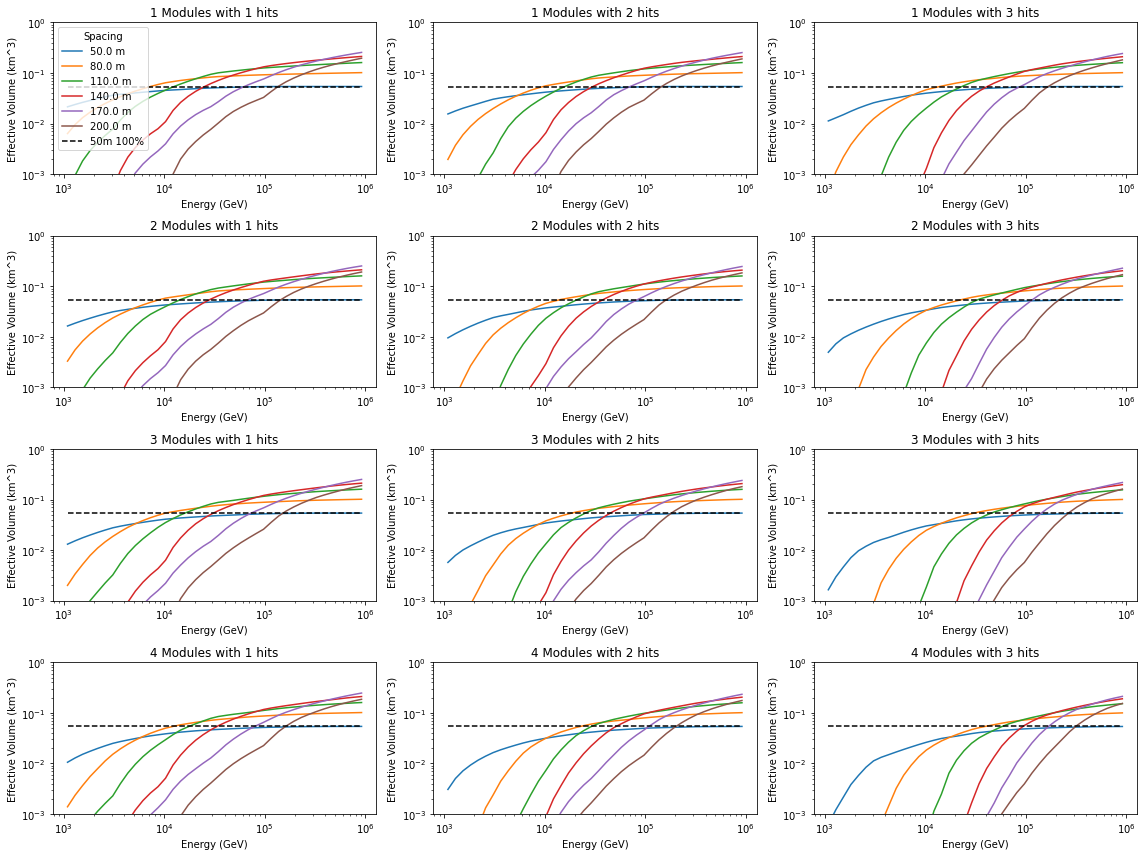

In [23]:
bc = 0.5*(a_eff_e_bins[1:] + a_eff_e_bins[:-1])

trigger_settings = [(1,1), (1, 2), (1, 3), (2, 1), (2,2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4,2), (4, 3)]

pos_res_thresh = 1

fig, axs = plt.subplots(4, 3, figsize=(4*4, 4*3))
aeff_df_ref = aeff_df.loc[(slice(None), slice(None), slice(None), 50)]


for (mt, ht), ax in zip(trigger_settings, axs.ravel()):

    for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
        ax.plot(10**bc, np.average(group["veff_hist"].values[0]/1E9, axis=0), label=f"{groupn} m")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Energy (GeV)")
        ax.set_ylabel("Effective Volume (km^3)")
        ax.set_ylim(1E-3, 1)
        ax.set_title(f"{mt} Modules with {ht} hits")
    ax.plot(10**bc, np.average(aeff_df_ref["veff_hist"].values[0]/1E9, axis=0), ls="--", color="k", label="50m 100%")
        
axs[0][0].legend(title="Spacing")

plt.tight_layout()
plt.savefig("../figures/em_casc_veff_nc_edep_theta_avg_triggers_pos_res1.png", dpi=150)





/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: ind

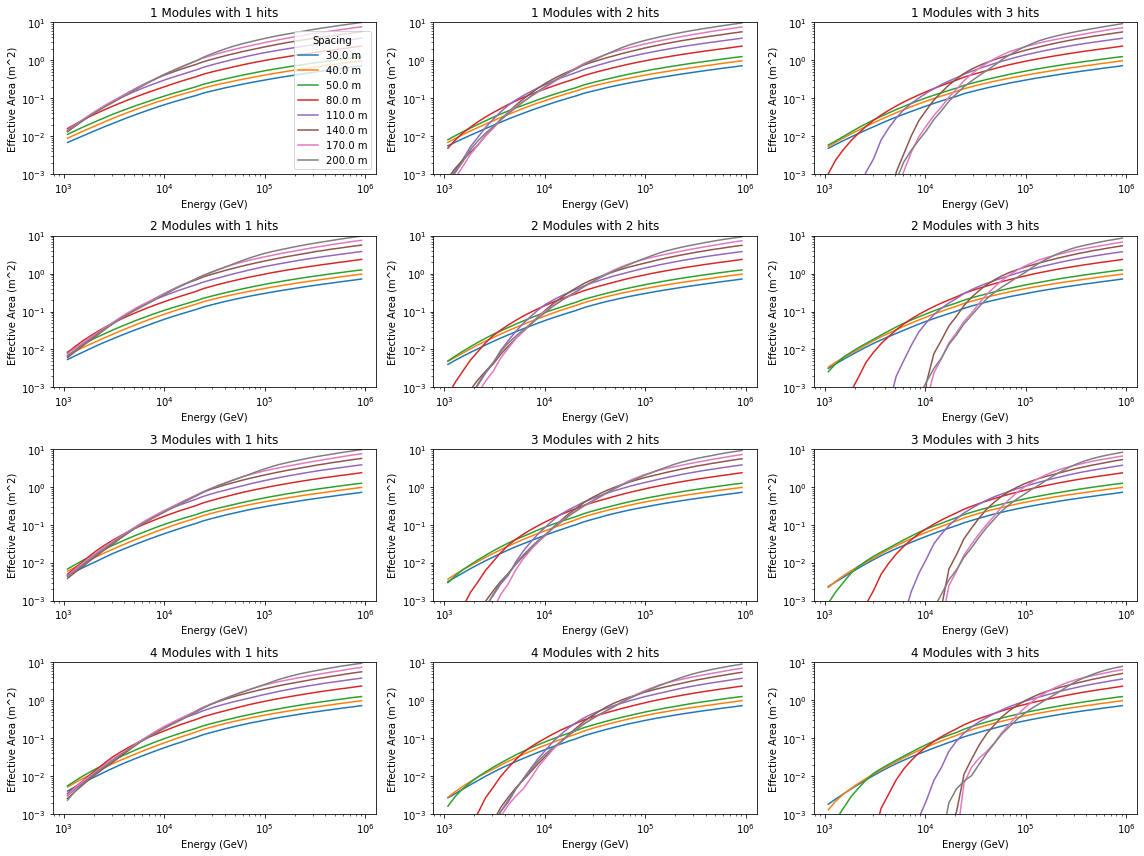

In [6]:
bc = 0.5*(a_eff_e_bins[1:] + a_eff_e_bins[:-1])

trigger_settings = [(1,1), (1, 2), (1, 3), (2, 1), (2,2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4,2), (4, 3)]

pos_res_thresh = None

fig, axs = plt.subplots(4, 3, figsize=(4*4, 4*3))

for (mt, ht), ax in zip(trigger_settings, axs.ravel()):

    for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
        ax.plot(10**bc, np.average(group["aeff_hist"].values[0], axis=0), label=f"{groupn} m")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Energy (GeV)")
        ax.set_ylabel("Effective Area (m^2)")
        ax.set_ylim(1E-3, 10)
        ax.set_title(f"{mt} Modules with {ht} hits")
axs[0][0].legend(title="Spacing")

plt.tight_layout()
plt.savefig("../figures/em_casc_aeff_nc_edep_theta_avg_triggers.png", dpi=150)





/tmp/ipykernel_172178/1057378841.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_172178/1057378841.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_172178/1057378841.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_172178/1057378841.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):


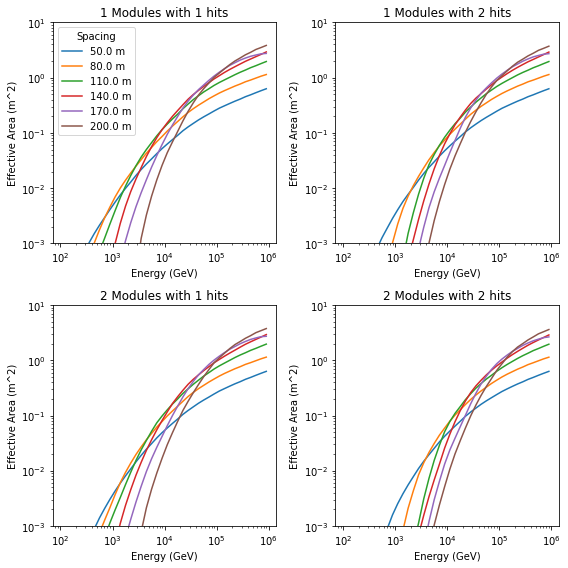

In [46]:
bc = 0.5*(a_eff_e_bins[1:] + a_eff_e_bins[:-1])

trigger_settings = [(1,1), (1, 2), (2, 1), (2,2)]

pos_res_thresh = 5

fig, axs = plt.subplots(2, 2, figsize=(4*2, 4*2))

for (mt, ht), ax in zip(trigger_settings, axs.ravel()):

    for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
        ax.plot(10**bc, np.average(group["aeff_hist"].values[0], axis=0), label=f"{groupn} m")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Energy (GeV)")
        ax.set_ylabel("Effective Area (m^2)")
        ax.set_ylim(1E-3, 10)
        ax.set_title(f"{mt} Modules with {ht} hits")
axs[0][0].legend(title="Spacing")

plt.tight_layout()
plt.savefig("../figures/em_casc_aeff_nc_edep_theta_avg_triggers.png", dpi=150)





In [30]:
aeff_df.index

MultiIndex([(1, 1, nan,  30.0),
            (2, 1, nan,  30.0),
            (3, 1, nan,  30.0),
            (4, 1, nan,  30.0),
            (5, 1, nan,  30.0),
            (1, 2, nan,  30.0),
            (2, 2, nan,  30.0),
            (3, 2, nan,  30.0),
            (4, 2, nan,  30.0),
            (5, 2, nan,  30.0),
            ...
            (3, 5, 2.0, 200.0),
            (3, 5, 5.0, 200.0),
            (4, 5, nan, 200.0),
            (4, 5, 1.0, 200.0),
            (4, 5, 2.0, 200.0),
            (4, 5, 5.0, 200.0),
            (5, 5, nan, 200.0),
            (5, 5, 1.0, 200.0),
            (5, 5, 2.0, 200.0),
            (5, 5, 5.0, 200.0)],
           names=['hit_threshold', 'module_threshold', 'min_pos_resolution', 'spacing'], length=650)

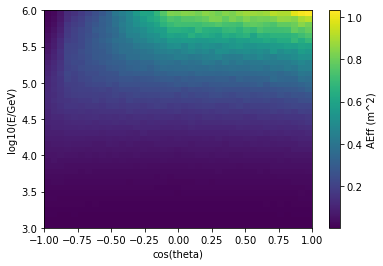

In [31]:
plt.figure()
plt.pcolormesh(a_eff_cos_bins, a_eff_e_bins, (aeff_df.loc[1, 1, None, 50].values[0]).T)
cbar = plt.colorbar()
cbar.set_label("AEff (m^2)")
plt.xlabel("cos(theta)")
plt.ylabel("log10(E/GeV)")
plt.savefig("../figures/aeff_cluster_nue_cc")

#np.savez("../data/aeff_cluster_100m_nue_cc cos_theta_edges=a_eff_cos_bins, log10_e_edges=a_eff_e_bins, aeff=aeff_hists[1])


In [53]:
efficiency * 0.21**2 / 100**2 * np.exp(-100/20) * 0.25

9.475237967463937e-10

In [54]:
efficiency

0.12755102040816327

In [51]:


efficiency

0.12755102040816327

In [52]:

np.exp(-100/20)

0.006737946999085467